In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

Мы будем работать с данными агрегатора такси [Sigma Cabs](https://www.kaggle.com/datasets/arashnic/taxi-pricing-with-mobility-analytics). В зависимости от характеристик поездки требуется предсказать один из трех типов повышенного ценообразования: [1, 2, 3]. Таким образом, это поможет компании оптимально мэтчить такси и клиентов. 

In [2]:
df = pd.read_csv('sigma_cabs.csv')
df.shape

(131662, 14)

In [3]:
# Занесем индекс колонку
df = df.set_index('Trip_ID')
df.head()

,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender,Surge_Pricing_Type
Trip_ID,,,,,,,,,,,,,
T0005689460,6.77,B,1.0,2.42769,A,A,3.90500,0,40.0,46,60,Female,2
T0005689461,29.47,B,10.0,2.78245,B,A,3.45000,0,38.0,56,78,Male,2
T0005689464,41.58,NaN,10.0,NaN,NaN,E,3.50125,2,NaN,56,77,Male,2
T0005689465,61.56,C,10.0,NaN,NaN,A,3.45375,0,NaN,52,74,Male,3
T0005689467,54.95,C,10.0,3.03453,B,A,3.40250,4,51.0,49,102,Male,2


Описание признаков:

1. **Trip_ID**: ID for TRIP
2. **Trip_Distance**: The distance for the trip requested by the customer
3. **TypeofCab**: Category of the cab requested by the customer
4. **CustomerSinceMonths**: Customer using cab services since n months; 0 month means current month
5. **LifeStyleIndex**: Proprietary index created by Sigma Cabs showing lifestyle of the customer based on their behaviour
6. **ConfidenceLifeStyle_Index**: Category showing confidence on the index mentioned above
7. **Destination_Type**: Sigma Cabs divides any destination in one of the 14 categories.
8. **Customer_Rating**: Average of life time ratings of the customer till date
9. **CancellationLast1Month**: Number of trips cancelled by the customer in last 1 month
10. **Var1**, **Var2** and **Var3**: Continuous variables masked by the company. Can be used for modelling purposes
11. **Gender**: Gender of the customer

**SurgePricingType**: Target (can be of 3 types)


### EDA 
Заполните пропуски в вещественных признаках медианой, а в категориальных - самым популярным классом. Изобразите марицу корреляций и выведите топ5 пар самых коррелированных признаков.

Так как в сумме уникальных значений различных категориальных признаков окажется не супер-много, примените `One-Hot-Encoding` для них. Не забудьте в методе `pd.get_dummies` указать параметр `drop_first=True`.

In [4]:
# Отбираем числовые колонки

numeric_cols = df.loc[:, df.dtypes != 'object'].columns
numeric_cols

Index(['Trip_Distance', 'Customer_Since_Months', 'Life_Style_Index',
       'Customer_Rating', 'Cancellation_Last_1Month', 'Var1', 'Var2', 'Var3',
       'Surge_Pricing_Type'],
      dtype='object')

In [5]:
# Заполняем пропуски в числовых колонках средним значением

for col in numeric_cols:
    if col != 'Surge_Pricing_Type':
        df[col] = df[col].fillna(df[col].mean())

In [6]:
df[numeric_cols].isna().sum()

Trip_Distance               0
Customer_Since_Months       0
Life_Style_Index            0
Customer_Rating             0
Cancellation_Last_1Month    0
Var1                        0
Var2                        0
Var3                        0
Surge_Pricing_Type          0
dtype: int64

In [7]:
# Матрица корреляций

corr_matrix = df[numeric_cols].corr()
corr_matrix

,Trip_Distance,Customer_Since_Months,Life_Style_Index,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Surge_Pricing_Type
Trip_Distance,1.000000,0.114340,0.468367,-0.054654,-0.007686,-0.030662,0.200456,0.231706,0.135928
Customer_Since_Months,0.114340,1.000000,0.119154,-0.049001,-0.006187,-0.006700,0.041766,0.110830,0.027202
Life_Style_Index,0.468367,0.119154,1.000000,0.189173,0.068176,-0.055873,0.215921,0.303296,-0.073682
Customer_Rating,-0.054654,-0.049001,0.189173,1.000000,0.003595,-0.007400,-0.302968,-0.227531,-0.155279
Cancellation_Last_1Month,-0.007686,-0.006187,0.068176,0.003595,1.000000,0.007550,0.095830,0.128686,0.185646
Var1,-0.030662,-0.006700,-0.055873,-0.007400,0.007550,1.000000,-0.031712,-0.041235,-0.026302
Var2,0.200456,0.041766,0.215921,-0.302968,0.095830,-0.031712,1.000000,0.683437,0.003437
Var3,0.231706,0.110830,0.303296,-0.227531,0.128686,-0.041235,0.683437,1.000000,-0.039309
Surge_Pricing_Type,0.135928,0.027202,-0.073682,-0.155279,0.185646,-0.026302,0.003437,-0.039309,1.000000


In [8]:
df['Var1']

Trip_ID
T0005689460     40.000000
T0005689461     38.000000
T0005689464     64.202698
T0005689465     64.202698
T0005689467     51.000000
                  ...    
T0005908509     61.000000
T0005908510     64.202698
T0005908512     64.202698
T0005908513     47.000000
T0005908514    102.000000
Name: Var1, Length: 131662, dtype: float64

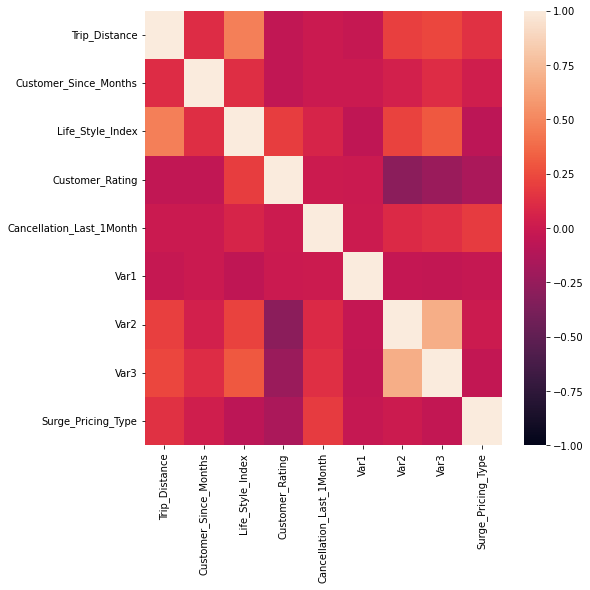

In [9]:
# Heat Map

fig = plt.figure(figsize=(8, 8))

sns.heatmap(corr_matrix, 
            xticklabels=corr_matrix.columns,
            yticklabels=corr_matrix.columns,
            vmax=1,
            vmin=-1)

plt.show()

In [10]:
# Top 5 самых скоррелированных фичей

def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop


def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]


print("Top Absolute Correlations")
print(get_top_abs_correlations(df[numeric_cols], 5))

Top Absolute Correlations
Var2              Var3                0.683437
Trip_Distance     Life_Style_Index    0.468367
Life_Style_Index  Var3                0.303296
Customer_Rating   Var2                0.302968
Trip_Distance     Var3                0.231706
dtype: float64


In [11]:
# Отбираем категориальные колонки

categorical_cols = df.loc[:, df.dtypes == 'object'].columns
categorical_cols

Index(['Type_of_Cab', 'Confidence_Life_Style_Index', 'Destination_Type',
       'Gender'],
      dtype='object')

In [12]:
# Заполняем прпуски в категориальных колнках самым популярным значением

for col in categorical_cols:
    most_freq = df.groupby(col).size().sort_values().index[-1]
    df[col] = df[col].fillna(most_freq)

In [13]:
df[categorical_cols].isna().sum()

Type_of_Cab                    0
Confidence_Life_Style_Index    0
Destination_Type               0
Gender                         0
dtype: int64

In [14]:
df

,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender,Surge_Pricing_Type
Trip_ID,,,,,,,,,,,,,
T0005689460,6.77,B,1.0,2.427690,A,A,3.90500,0,40.000000,46,60,Female,2
T0005689461,29.47,B,10.0,2.782450,B,A,3.45000,0,38.000000,56,78,Male,2
T0005689464,41.58,B,10.0,2.802064,B,E,3.50125,2,64.202698,56,77,Male,2
T0005689465,61.56,C,10.0,2.802064,B,A,3.45375,0,64.202698,52,74,Male,3
T0005689467,54.95,C,10.0,3.034530,B,A,3.40250,4,51.000000,49,102,Male,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
T0005908509,11.72,D,1.0,2.742290,A,A,3.28500,0,61.000000,47,76,Male,3
T0005908510,74.81,C,7.0,2.810590,C,A,0.44500,0,64.202698,63,88,Male,2
T0005908512,40.17,C,10.0,2.995650,B,A,3.33625,0,64.202698,48,75,Female,2


In [15]:
# OneHotEncoding для категориальных фичей

for col in categorical_cols:
    one_hot = pd.get_dummies(df[col], drop_first=True, prefix=col)
    df = pd.concat((df, one_hot), axis=1)
    df = df.drop(col, axis=1)

In [16]:
df.shape

(131662, 29)

### Training

In [17]:
np.random.seed(2022)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = df.drop('Surge_Pricing_Type', axis=1)
y = df['Surge_Pricing_Type']

In [18]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, 
                                                     test_size=0.2, 
                                                     shuffle=True, 
                                                     random_state=2022)

**Задание 1.** Обучите One-vs-Rest Logreg. Не забудьте в шаг добавить стандартизацию данных (через `StandardScaler`) Посчитайте precision, recall, f1-score и усредните по всем классам с помощью micro, macro и weighted avg. Здесь и далее округляйте до 3 знака после запятой.

Чтобы отдельно и долго не вычислять метрики, можно воспользоваться `classification_report` из `sklearn.metrics`!

In [19]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

pipe_one_rest = Pipeline([('scaler', StandardScaler()), 
                          ('one_vs_rest', OneVsRestClassifier(LogisticRegression()))])

pipe_one_rest.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('one_vs_rest',
                 OneVsRestClassifier(estimator=LogisticRegression()))])

In [20]:
from sklearn.metrics import classification_report

print(classification_report(y_test, pipe_one_rest.predict(X_test), digits=3))

              precision    recall  f1-score   support

           1      0.722     0.542     0.619      5372
           2      0.636     0.835     0.722     11349
           3      0.741     0.571     0.645      9612

    accuracy                          0.679     26333
   macro avg      0.700     0.649     0.662     26333
weighted avg      0.692     0.679     0.673     26333



Подберите оптимальные гиперпараметры модели с помощью `GridSearchCV()` из предложенных. Для лучшего набора гиперпараметров посчитайте те же самые метрики. Валидировать параметры необходимо по `accuracy`. В этот раз проведем настояющую процедуру Кросс-Валидации! 

Для этого в метод `fit` передадим тренировочную часть наших данных, в параметр `cv` ничего не будем передавать (по дефолту 5-fold Кросс-Валидация будет проведена), а итоговые метрики замерим на тесте!

In [21]:
pipe_one_rest.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('one_vs_rest', OneVsRestClassifier(estimator=LogisticRegression()))],
 'verbose': False,
 'scaler': StandardScaler(),
 'one_vs_rest': OneVsRestClassifier(estimator=LogisticRegression()),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'one_vs_rest__estimator__C': 1.0,
 'one_vs_rest__estimator__class_weight': None,
 'one_vs_rest__estimator__dual': False,
 'one_vs_rest__estimator__fit_intercept': True,
 'one_vs_rest__estimator__intercept_scaling': 1,
 'one_vs_rest__estimator__l1_ratio': None,
 'one_vs_rest__estimator__max_iter': 100,
 'one_vs_rest__estimator__multi_class': 'auto',
 'one_vs_rest__estimator__n_jobs': None,
 'one_vs_rest__estimator__penalty': 'l2',
 'one_vs_rest__estimator__random_state': None,
 'one_vs_rest__estimator__solver': 'lbfgs',
 'one_vs_rest__estimator__tol': 0.0001,
 'one_vs_rest__estimator__verbose': 0,
 'one_vs_rest__estimator__warm_start': False,
 'one_vs_rest__estimato

In [22]:
param_grid = {'one_vs_rest__estimator__penalty': ['l1', 'l2', 'elasticnet'],
              'one_vs_rest__estimator__C': [0.001, 0.01, 0.1, 1]}

In [23]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

search = GridSearchCV(pipe_one_rest, param_grid, scoring='accuracy')

search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('one_vs_rest',
                                        OneVsRestClassifier(estimator=LogisticRegression()))]),
             param_grid={'one_vs_rest__estimator__C': [0.001, 0.01, 0.1, 1],
                         'one_vs_rest__estimator__penalty': ['l1', 'l2',
                                                             'elasticnet']},
             scoring='accuracy')

In [24]:
search.best_params_

{'one_vs_rest__estimator__C': 0.001, 'one_vs_rest__estimator__penalty': 'l2'}

In [25]:
pipe_one_rest.set_params(one_vs_rest__estimator__C=0.001, one_vs_rest__estimator__penalty='l2')

Pipeline(steps=[('scaler', StandardScaler()),
                ('one_vs_rest',
                 OneVsRestClassifier(estimator=LogisticRegression(C=0.001)))])

In [26]:
pipe_one_rest.fit(X_train, y_train)
print(classification_report(y_test, pipe_one_rest.predict(X_test), digits=3))

              precision    recall  f1-score   support

           1      0.741     0.534     0.621      5372
           2      0.635     0.839     0.723     11349
           3      0.742     0.576     0.648      9612

    accuracy                          0.681     26333
   macro avg      0.706     0.650     0.664     26333
weighted avg      0.696     0.681     0.675     26333



Изобразите три калибровочные кривые для Logistic Classifier: 0-vs-rest, 1-vs-rest, 2-vs-rest. Хорошо ли откалиброван обученный классификатор? 

Заметьте, что `predict_proba` возвращает список из вероятностей для всех наших классов!

In [27]:
pipe_one_rest.classes_

array([1, 2, 3])

In [28]:
pipe_one_rest.predict_proba(X_test)

array([[0.32584652, 0.27113827, 0.4030152 ],
       [0.02345022, 0.54099568, 0.4355541 ],
       [0.02308938, 0.55718697, 0.41972365],
       ...,
       [0.48776085, 0.10509241, 0.40714675],
       [0.56561536, 0.180277  , 0.25410763],
       [0.13231086, 0.6003208 , 0.26736833]])

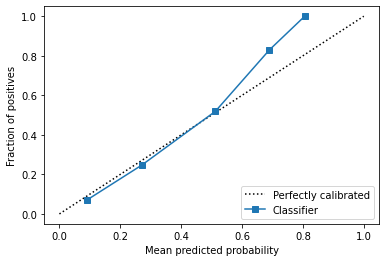

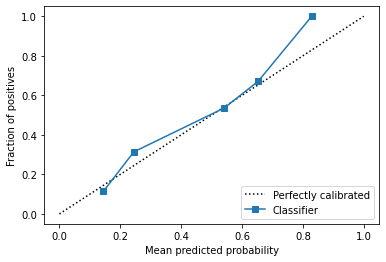

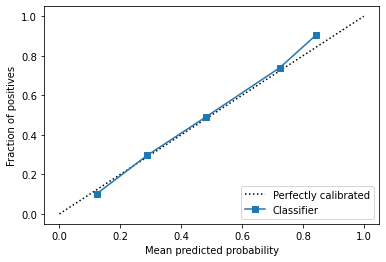

In [29]:
from sklearn.calibration import CalibrationDisplay

for target_class in range(3):
    CalibrationDisplay.from_predictions((y_test == target_class + 1).astype(float),
                                        pipe_one_rest.predict_proba(X_test)[:, target_class])

**Задание 2.** Обучите логистическую регрессию с гиперпараметрами из первого задания на полиномиальных признаках до 4 степени. Сравните метрики с первым заданием.


Пример: Пусть у нас был единственный признак 

$$
d_j = [1, 2, 3, 4]
$$

Тогда полиномиальные признаки до 4 степени от такого будут иметь вид:

$$
d_j^1 = [1, 2, 3, 4]
$$

$$
d_j^2 = [1, 4, 9, 16]
$$

$$
d_j^3 = [1, 8, 27, 64]
$$

$$
d_j^4 = [1, 16, 81, 256]
$$

P.S. Бинарные колонки нет смысла возводить в какие-то степени, поэтому возьмем исключительно вещественные из базовых. 

Для этого можно воспользоваться классическим циклом (или уроком из занятия про `Sberbank Housing Market`). Положите модифицированный датасет в переменную `X_polinomial`!

P.S.S Зачастую еще, создаваю полиномиальные фичи, учитывают "пересечения" признаков, то есть, например, из векторов признаков $d_j, d_i$ генерируют не просто новые степени $d_j^2, d_i^2, d_j^3, d_i^3...$, а еще и признаки вида $d_j \cdot d_i, d_j^2 \cdot d_i, d_j \cdot d_i^2...$, но здесь ограничьтесь просто степенями!

In [30]:
# Создание полиномиальных признаков

X_polinomial = X.copy()
numeric_cols_pol = numeric_cols.drop('Surge_Pricing_Type')

for col in numeric_cols_pol:
    for power in [1, 2, 3, 4]:
        pol_col = (X_polinomial[col] ** power).to_frame().rename({col: f'{col}_{power}'}, axis=1)
        X_polinomial = pd.concat((X_polinomial, pol_col), axis=1)

In [31]:
X_pol_train, X_pol_test, y_train, y_test  = train_test_split(X_polinomial, y, 
                                                             test_size=0.2, 
                                                             shuffle=True, 
                                                             random_state=2022)

In [32]:
pipe_one_rest.fit(X_pol_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('one_vs_rest',
                 OneVsRestClassifier(estimator=LogisticRegression(C=0.001)))])

In [33]:
print(classification_report(y_test, pipe_one_rest.predict(X_pol_test), digits=3))

              precision    recall  f1-score   support

           1      0.751     0.532     0.623      5372
           2      0.636     0.835     0.722     11349
           3      0.739     0.588     0.655      9612

    accuracy                          0.683     26333
   macro avg      0.709     0.651     0.667     26333
weighted avg      0.697     0.683     0.677     26333



По аналогии с первым заданием изобразите три калибровочные кривые. Стало ли лучше?

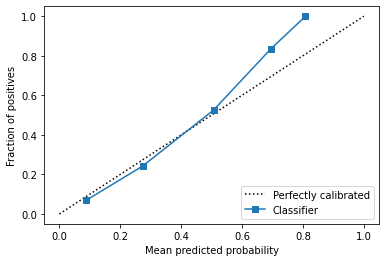

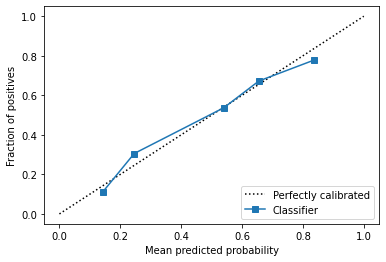

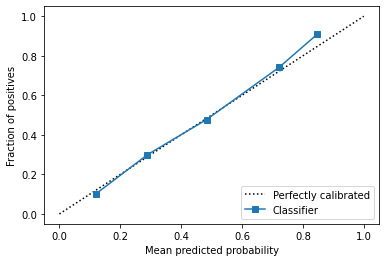

In [34]:
for target_class in range(3):
    CalibrationDisplay.from_predictions((y_test == target_class + 1).astype(float),
                                         pipe_one_rest.predict_proba(X_pol_test)[:, target_class])

**Задание 3.** Обучите на датасете без полиномиальных признаков One-vs-One `SGDClassifier` из `sklearn.linear_model`, который использует стохастический градиентный спуск (узнаете о нем позже) и может обучать как `SVM`, так и, например, `LogReg`, если указать в качестве параметра `loss` либо `hinge`, либо `log` соответственно!

Посчитайте precision, recall, f1-score и усредните по всем классам с помощью micro, macro и weighted avg.

In [35]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, 
                                                     test_size=0.2, 
                                                     shuffle=True, 
                                                     random_state=2022)

In [36]:
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsOneClassifier

pipe_one_one = Pipeline([('scaler', StandardScaler()), 
                         ('one_vs_one', OneVsOneClassifier(SGDClassifier()))])

pipe_one_one.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('one_vs_one', OneVsOneClassifier(estimator=SGDClassifier()))])

In [37]:
print(classification_report(y_test, pipe_one_one.predict(X_test), digits=3))

              precision    recall  f1-score   support

           1      0.743     0.525     0.615      5372
           2      0.625     0.871     0.728     11349
           3      0.759     0.531     0.625      9612

    accuracy                          0.676     26333
   macro avg      0.709     0.642     0.656     26333
weighted avg      0.698     0.676     0.667     26333



Подберите оптимальные гиперпараметры модели с помощью `GridSearchCV()`. При этом переберите всевозможные функции потерь. Таким образом, при `loss = 'hinge'`, мы обучим SVM, при `loss = 'log'` мы обучим логистическую регрессию и т.д.

Используйте прием с Кросс-Валидацией при подборе параметров, как ранее, а также замерьте метрики на тесте.

In [38]:
param_grid = {'one_vs_one__estimator__loss': ['hinge', 'log', 'modified_huber'],
              'one_vs_one__estimator__penalty': ['l1', 'l2'],
              'one_vs_one__estimator__alpha': [0.001, 0.01, 0.1]}

In [39]:
search = GridSearchCV(pipe_one_one, param_grid, scoring='accuracy')

search.fit(X_test, y_test)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('one_vs_one',
                                        OneVsOneClassifier(estimator=SGDClassifier()))]),
             param_grid={'one_vs_one__estimator__alpha': [0.001, 0.01, 0.1],
                         'one_vs_one__estimator__loss': ['hinge', 'log',
                                                         'modified_huber'],
                         'one_vs_one__estimator__penalty': ['l1', 'l2']},
             scoring='accuracy')

In [40]:
print(classification_report(y_test, search.predict(X_test), digits=3))

              precision    recall  f1-score   support

           1      0.751     0.526     0.619      5372
           2      0.633     0.842     0.723     11349
           3      0.742     0.576     0.649      9612

    accuracy                          0.681     26333
   macro avg      0.709     0.648     0.664     26333
weighted avg      0.697     0.681     0.675     26333



Можно ли однозначной сказать, какой подход оказался лучше: One-vs-Rest или One-vs-One?

Нет, поскольку метрики для обеих моделей практически не различаются.